In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model

from scipy.stats import linregress
from contact_resistance_v2 import idea

# pd.set_option('display.max_rows', None)

In [ ]:
# MODEL
def r_t(s, r_s, l_t, N, W, L):
    return (r_s * s / (N * W + (N-1) * (2 *s + L))) + (2 * r_s * l_t / (N * W + (N-1) * (2 *s + L)))

#Create model and parameters
gmodel5 = Model(r_t)
param5 = gmodel5.make_params()
param5['r_s'].set(value = 1e10, min = 0)
param5['l_t'].set(value = 1, min = 0)
param5['L'].set(value = 3200e-4, vary = False)
param5['W'].set(value = 5e-4, vary = False)
param5['N'].set(value = 60, vary = False)

In [ ]:
col_iv = ['Potential (V)', 'Current (A)', 'Time (s)']
col_new_df = ['Spacing', 'Potential (V)', 'Current (A)']

def spacing(files, sample):
    new_df = pd.DataFrame()
    n = 0
    for i in files:         # files.sort(key = (lambda x: x[-6:-4])) # sort files by last part of string
        df = pd.read_csv(i, sep = ';', names = col_iv, skiprows = 1)
        if i[-5:-4] == '1':
            label = 2e-4
        elif i[-5:-4] == '2':
            label = 5e-4
        elif i[-5:-4] == '3':
            label = 10e-4
        elif i[-5:-4] == '4':
            label = 20e-4
        df[col_new_df[0]] = label
        # df['Sample'] = sample
        # df['Column'] = i[-10:-8]
        new_df = pd.concat([new_df, df])
        n += 1
    return new_df.reset_index(drop=True)

In [ ]:
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_24'
files = [os.path.join(path, i) for i in os.listdir(path)]
df_substrate = spacing(files, '0G_24')

In [ ]:
path_aut = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_25'
files_aut = [os.path.join(path_aut, i) for i in os.listdir(path_aut)]
sample = '0G_25'
df_sample = spacing(files_aut, sample)
df_corr = pd.DataFrame()

spacing = [2e-4, 5e-4, 10e-4, 20e-4]
for i in spacing:
    sam = df_sample[df_sample.Spacing == i]
    subs = df_substrate[df_substrate.Spacing == i]
    correct = sam - subs
    df_corr = pd.concat([df_corr, correct])
df_corr[col_iv[0]] = df_sample[col_iv[0]]
df_corr[col_iv[0]] = df_sample[col_iv[0]]
df_corr[col_new_df[0]] = df_sample[col_new_df[0]]

sns.lineplot(data = df_corr, x = col_iv[0], y = col_iv[1], hue = 'Spacing')


<BarContainer object of 1 artists>

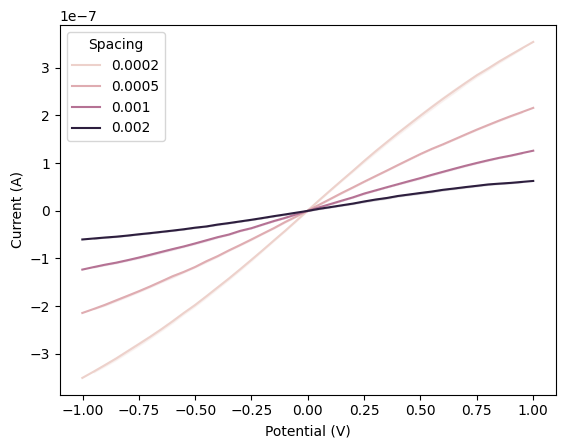

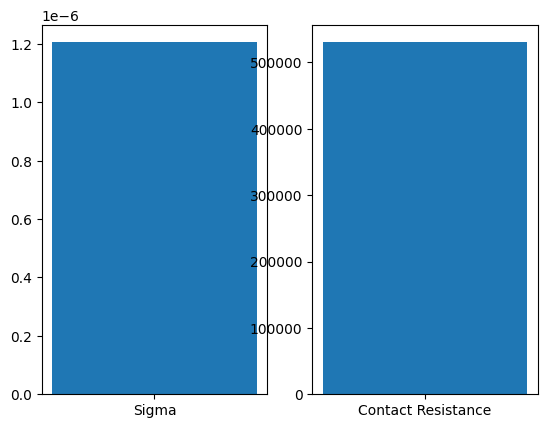

In [109]:
sns.lineplot(data = df_corr, x = col_iv[0], y = col_iv[1], hue = 'Spacing')


resistance = pd.DataFrame(columns=['Resistance', 'Spacing', 'r^2', 'stderr' ])
n = 0
for i in spacing:
    corr = df_sample[df_corr.Spacing == i]
    slope, intercept, rvalue, pvalue, stderr = linregress(corr[col_iv[0]], corr[col_iv[1]])
    r = 1/ slope
    resistance.loc[n] = [r, i, rvalue**2, stderr]
    # plt.plot(df_corr[col_iv[0]], df_corr[col_iv[0]] * slope + intercept)
    
    n += 1

result = gmodel5.fit(resistance['Resistance'], param5, s = resistance['Spacing'])
rc2 = gmodel5.eval(result.params, s = 0)
rs = result.values['r_s']
sigma = 1/ (rs * 80 *1e-7)

fig, ax = plt.subplots(1,3)
ax[0].bar(['Sigma'], [sigma])
ax[1].bar(['Contact Resistance'], [rc2 / 2])

In [ ]:
# result_all = gmodel5.fit(r_aut[col_r[1]], param5, s = r_aut[col_r[0]])
# rc2_all = gmodel5.eval(result_all.params, s = 0)
# rs_all = result_all.values['r_s']
# rs_err = result_all.params['r_s'].stderr
# sigma_all = 1/  (rs_all * thickness * 1e-7)
# sigma_err = 1/  (rs_err * thickness * 1e-7)
# r_aut['Fit'] = result_all.best_fit
# r_aut['Sample'] = sample        
# values.loc[0] = [rs_all, rc2_all / 2, sigma_all, sample]
# # return df_aut, r_aut, values

In [ ]:


# path_save = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\Results_susbtrate_correction'

# files_aut = [os.path.join(path_aut, i) for i in os.listdir(path_aut)]
# rt, tlm, val = idea.fit(files_aut, 80, sample)
# fig, ax = plt.subplots(dpi = 200)
# sns.lineplot(data = tlm, x = 'Spacing ($\mu$m)', y = 'Resistance (M$\Omega$)', errorbar = 'sd', marker = 'o', linestyle = '', err_style='bars', label = 'Data') #, style = 'Column')
# # sns.scatterplot(data = tlm, x = 'Spacing ($\mu$m)', y = 'Resistance (M$\Omega$)')
# sns.lineplot(data = tlm, x = 'Spacing ($\mu$m)', y = 'Fit', label = 'Fit') #, hue = 'Column')
# ax.xaxis.set_major_formatter(lambda x, pos: '{:.1f}'.format(x * 1e4))
# ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x / 1e6))
# plt.title(sample)